In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
%matplotlib inline

In [74]:
df_census = pd.read_csv("/Users/giuliopiccolo/Desktop/lab/project/dataset/NYC_census_2017.csv", index_col=0)
df_blocks = pd.read_csv("/Users/giuliopiccolo/Desktop/lab/project/dataset/NYC_bloc_loc.csv")

In [75]:
print("DataFrame contains", df_census.shape[0], "rows and", df_census.shape[1], "columns.")

DataFrame contains 2167 rows and 35 columns.


In [76]:
print("There are",  df_census.isnull().sum().sum() , "missing values, representing", round(100*df_census.isnull().sum().sum() / (df_census.shape[0]*df_census.shape[1]), 3), "% of the total.")

There are 1269 missing values, representing 1.673 % of the total.


In [78]:
# How good is this df?
# missing values
total = df_census.isnull().sum().sort_values(ascending=False)
percent = (df_census.isnull().sum()/df_census.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['NAs', 'Percent'])
missing_data.head(20)

,NAs,Percent
IncomeErr,66,0.030457
Income,66,0.030457
MeanCommute,61,0.028150
ChildPoverty,60,0.027688
IncomePerCapErr,46,0.021228
IncomePerCap,46,0.021228
Drive,43,0.019843
FamilyWork,43,0.019843
Service,43,0.019843
Office,43,0.019843


This dataframe is quite good. I tought to apply some averaging technique but it is unecessary, data are too good. [semicit]
I don't believe about the real need to continue the cleaning activity around here. Let's make some data viz.

We need to merge the two datasets in order to campute a map of CensusBlock. We first need to identify the census tracts associated with our locations. I will use data coordinates in the df_block dataset, but in general, I will use the df_block as a point of reference. 
In order to accomplish my goal, I take the coordinate (df_block) and perform a left join (SQL docet) with df_census values as keys. Since df_census is only for NYC itself, I will filter out everything outside the city. 

In [79]:
#datasets merge
df_blocks = df_blocks[df_blocks.County.isin(['Bronx','Kings','New York','Queens','Richmond'])]
df_blocks['Tract'] = df_blocks.BlockCode // 10000
df_blocks = df_blocks.merge(df_census,how='left',right_index=True,left_on='Tract')

df_blocks.head()

,Latitude,Longitude,BlockCode,County_x,State,Tract,County_y,Borough,TotalPop,Men,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
15,40.48,-74.232513,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
16,40.48,-74.229347,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
17,40.48,-74.226181,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
18,40.48,-74.223015,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
19,40.48,-74.219849,360859901000011,Richmond,NY,36085990100,Richmond,Staten Island,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [84]:
#df_blocks.dtypes

In [89]:
# Income is object but should be numeric
df_blocks['Income'] = pd.to_numeric(df_blocks['Income'], errors='coerce')

Converting coordinates to a 2-dimensional array.

In [90]:
def convert_to_2d(lats,lons,values):
    lat_min = 40.48 # according to Google
    lon_min = -74.28
    lat_max = 40.93
    lon_max = -73.65
    # matrix in which each returned argument has the same shape
    lon_vals = np.mgrid[lon_min:lon_max:200j]
    lat_vals = np.mgrid[lat_min:lat_max:200j]
    map_values = np.zeros([200,200])
    dlat = lat_vals[1] - lat_vals[0]
    dlon = lon_vals[1] - lon_vals[0]
    for lat,lon,value in zip(lats,lons,values):
        # round elements to the nearest int
        lat_idx = int(np.rint((lat - lat_min) / dlat))
        lon_idx = int(np.rint((lon-lon_min) / dlon ))        
        if not np.isnan(value):
            map_values[lon_idx,lat_idx] = value
    return lat_vals,lon_vals,map_values

Now we can finally plot the matrix with a colorbar.

In [91]:
def make_plot(data_values,title='',colors=''):
    lat_vals,lon_vals,values = convert_to_2d(df_blocks.Latitude,df_blocks.Longitude,data_values)
    fig = plt.figure(1,figsize=[10,10])
    limits = np.min(lon_vals),np.max(lon_vals),np.min(lat_vals),np.max(lat_vals)
    
    im = plt.imshow(values.T,origin="lower", cmap=colors, extent=limits)
    plt.xlabel('Longitude [degrees]')
    plt.ylabel('Latitude [degrees]')
    plt.title(title)
    plt.colorbar(im,fraction=0.035, pad=0.04)
    
    plt.show()

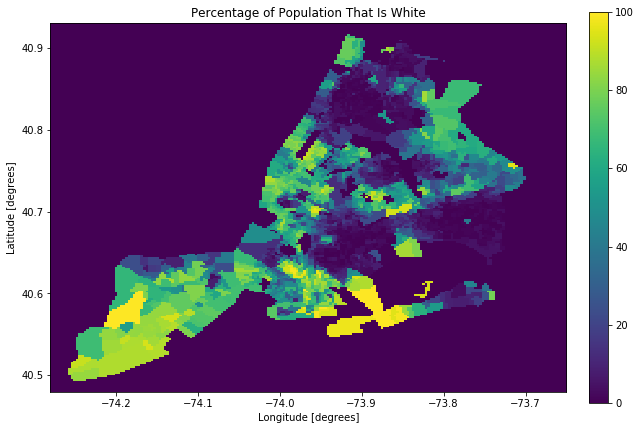

In [92]:
# let's plot White people of White
make_plot(df_blocks.White,colors='viridis',title='Percentage of Population That Is White')

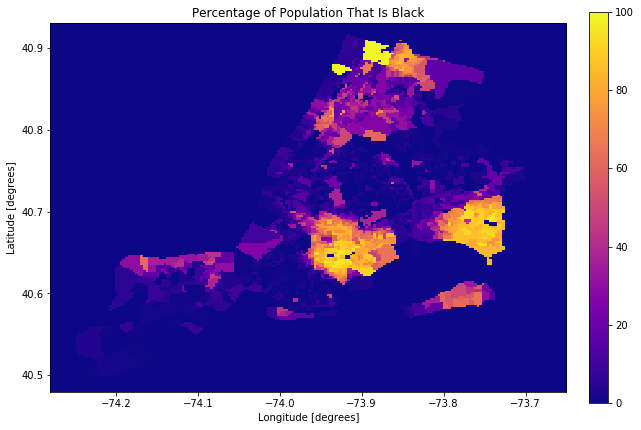

In [93]:
# let's plot Black people of NYC
make_plot(df_blocks.Black,colors='plasma',title='Percentage of Population That Is Black')

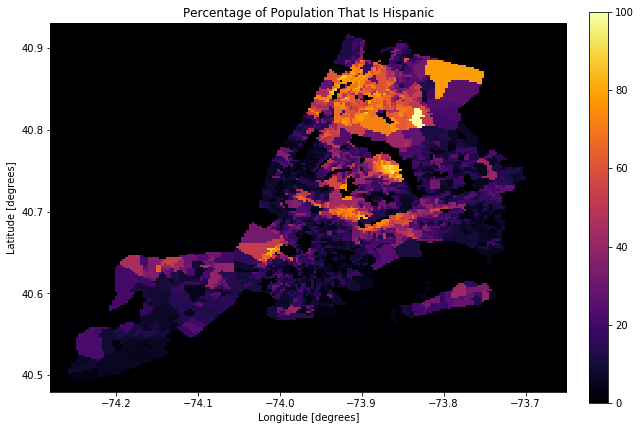

In [94]:
# let's plot Hispanic people of NYC
make_plot(df_blocks.Hispanic,colors='inferno',title='Percentage of Population That Is Hispanic')

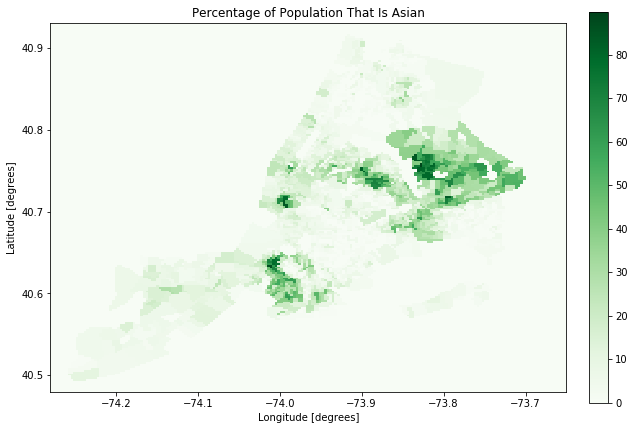

In [95]:
# let's plot Asian people of NYC
make_plot(df_blocks.Asian,colors='Greens',title='Percentage of Population That Is Asian')

In [96]:
df_blocks.describe()

,Latitude,Longitude,BlockCode,Tract,TotalPop,Men,Women,Hispanic,White,Black,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,12905.000000,12905.000000,1.290500e+04,1.290500e+04,12904.000000,12904.000000,12904.000000,12904.000000,12904.000000,12904.000000,...,12735.000000,12735.000000,12735.000000,11864.000000,12904.000000,12735.000000,12735.000000,12735.000000,12735.000000,12735.000000
mean,40.697219,-73.937233,3.605950e+14,3.605950e+10,4072.411655,1974.352991,2098.058664,23.531308,42.936601,19.622241,...,6.549501,1.961641,4.149541,41.353911,1854.982409,78.015556,16.404162,5.467311,0.114605,8.432344
std,0.101636,0.133826,2.866075e+11,2.866075e+07,2749.633291,1327.680939,1481.823863,21.212198,32.971692,27.265974,...,8.297716,3.708480,7.516663,6.959058,1347.000420,8.576135,8.591186,4.717003,0.406091,5.936121
min,40.493568,-74.257839,3.600500e+14,3.600500e+10,8.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,15.200000,0.000000,38.600000,0.000000,0.000000,0.000000,0.000000
25%,40.613417,-74.007739,3.604703e+14,3.604703e+10,2378.000000,1165.000000,1207.000000,7.800000,8.475000,0.900000,...,1.300000,0.000000,1.200000,37.400000,1057.000000,73.600000,10.500000,2.800000,0.000000,5.000000
50%,40.690302,-73.915930,3.608101e+14,3.608101e+10,3756.000000,1800.000000,1922.000000,16.600000,44.700000,5.100000,...,4.000000,1.000000,2.500000,41.500000,1662.000000,78.100000,15.900000,4.900000,0.000000,7.500000
75%,40.773970,-73.833618,3.608112e+14,3.608112e+10,5428.000000,2648.000000,2837.000000,31.900000,71.200000,27.300000,...,8.100000,2.300000,4.700000,45.700000,2430.000000,83.200000,21.300000,7.300000,0.000000,10.900000
max,40.916432,-73.700653,3.608503e+14,3.608503e+10,28926.000000,13460.000000,15466.000000,100.000000,100.000000,100.000000,...,100.000000,55.600000,100.000000,70.500000,12780.000000,100.000000,53.700000,61.400000,3.900000,62.700000
